# Localization of two rectangles

Localization of two rectangles in a given image

The notebook program is modified based on object detection with neural networks — a simple tutorial using keras by Johannes Rieke.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

### Create images with random rectangles and bounding boxes. 

In [2]:
num_imgs = 50000

img_size = 8
min_rect_size = 1
max_rect_size = 4
num_objects = 2

bboxes = np.zeros((num_imgs, num_objects, 4))
imgs = np.zeros((num_imgs, img_size, img_size))

for i_img in range(num_imgs):
    for i_object in range(num_objects):
        w, h = np.random.randint(min_rect_size, max_rect_size, size=2)
        x = np.random.randint(0, img_size - w)
        y = np.random.randint(0, img_size - h)
        imgs[i_img, x:x+w, y:y+h] = 1.
        bboxes[i_img, i_object] = [x, y, w, h]
        
imgs.shape, bboxes.shape

((50000, 8, 8), (50000, 2, 4))

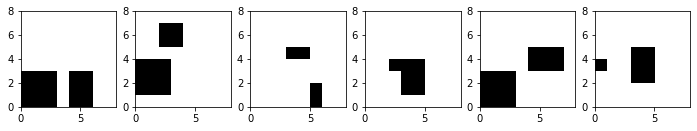

In [3]:
plt.figure(figsize=(12, 3))
for i in range(1, 7):
    plt.subplot(1, 6, i)
    plt.imshow(imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
plt.show()
# for bbox in bboxes[i]:
#     plt.gca().add_patch(matplotlib.patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], ec='r', fc='none'))

### Model Input and Output
Input: normalized image
Output: bounding box (bx1, by1, bw1, bh1, bx2, by2, bw2, bh2)

In [4]:
# Reshape and normalize the data to mean 0 and std 1. 
X = (imgs.reshape(num_imgs, -1) - np.mean(imgs)) / np.std(imgs)
X.shape, np.mean(X), np.std(X)

((50000, 64), 7.79953879259665e-17, 0.9999999999999996)

In [5]:
# Normalize x, y, w, h by img_size, so that all values are between 0 and 1.
# Important: Do not shift to negative values (e.g. by setting to mean 0), because the IOU calculation needs positive w and h.
y = bboxes.reshape(num_imgs, -1) / img_size
y.shape, np.mean(y), np.std(y)

((50000, 8), 0.281218125, 0.1750338107951843)

### Split training and test.

In [6]:
i = int(0.8 * num_imgs)
train_X = X[:i]
test_X = X[i:]
train_y = y[:i]
test_y = y[i:]
test_imgs = imgs[i:]
test_bboxes = bboxes[i:]

### Build the model.

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
model = Sequential([
        Dense(256, input_dim=X.shape[-1]), 
        Activation('relu'), 
        Dropout(0.4), 
        Dense(y.shape[-1])
    ])
model.compile(Adam(0.0001, beta_1=0.5), 'mse')

In [8]:
# Flip bboxes during training.
# Note: The validation loss is always quite big here because we don't flip the bounding boxes for the validation data. 
def IOU(bbox1, bbox2):
    '''Calculate overlap between two bounding boxes [x, y, w, h] as the area of intersection over the area of unity'''
    x1, y1, w1, h1 = bbox1[0], bbox1[1], bbox1[2], bbox1[3]
    x2, y2, w2, h2 = bbox2[0], bbox2[1], bbox2[2], bbox2[3]

    w_I = min(x1 + w1, x2 + w2) - max(x1, x2)
    h_I = min(y1 + h1, y2 + h2) - max(y1, y2)
    if w_I <= 0 or h_I <= 0:  # no overlap
        return 0
    I = w_I * h_I

    U = w1 * h1 + w2 * h2 - I

    return I / U

def distance(bbox1, bbox2):
    return np.sqrt(np.sum(np.square(bbox1[:2] - bbox2[:2])))

### Training without flipping

In [9]:
num_epochs = 30
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

model.fit(train_X, flipped_train_y, nb_epoch=num_epochs, validation_data=(test_X, test_y), verbose=2)


#     for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
#         flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
#         mse = np.mean(np.square(pred_bboxes - exp_bboxes))
#         mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
#         iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
#         iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
#         dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + distance(pred_bboxes[4:], exp_bboxes[4:])
#         dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + distance(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
#         if mse_flipped < mse:  # you can also use iou or dist here
#             flipped_train_y[i] = flipped_exp_bboxes
#             flipped[i, epoch] = 1
#             mses_epoch[i, epoch] = mse_flipped / 2.
#             ious_epoch[i, epoch] = iou_flipped / 2.
#             dists_epoch[i, epoch] = dist_flipped / 2.
#         else:
#             mses_epoch[i, epoch] = mse / 2.
#             ious_epoch[i, epoch] = iou / 2.
#             dists_epoch[i, epoch] = dist / 2.
    
#     print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
#     print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
#     print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
#     print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
#     print()

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 - 3s - loss: 0.1965 - val_loss: 0.0362
Epoch 2/30
40000/40000 - 2s - loss: 0.0568 - val_loss: 0.0257
Epoch 3/30
40000/40000 - 2s - loss: 0.0336 - val_loss: 0.0219
Epoch 4/30
40000/40000 - 2s - loss: 0.0259 - val_loss: 0.0200
Epoch 5/30
40000/40000 - 2s - loss: 0.0225 - val_loss: 0.0190
Epoch 6/30
40000/40000 - 2s - loss: 0.0207 - val_loss: 0.0183
Epoch 7/30
40000/40000 - 2s - loss: 0.0197 - val_loss: 0.0179
Epoch 8/30
40000/40000 - 2s - loss: 0.0190 - val_loss: 0.0174
Epoch 9/30
40000/40000 - 2s - loss: 0.0185 - val_loss: 0.0172
Epoch 10/30
40000/40000 - 2s - loss: 0.0180 - val_loss: 0.0170
Epoch 11/30
40000/40000 - 2s - loss: 0.0178 - val_loss: 0.0168
Epoch 12/30
40000/40000 - 2s - loss: 0.0175 - val_loss: 0.0167
Epoch 13/30
40000/40000 - 2s - loss: 0.0173 - val_loss: 0.0165
Epoch 14/30
40000/40000 - 2s - loss: 0.0172 - val_loss: 0.0164
Epoch 15/30
40000/40000 - 2s - loss: 0.0170 - val_loss: 0.0164
Epoch 16/30
40

### Results of training without flipping

In [10]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 2, 4)

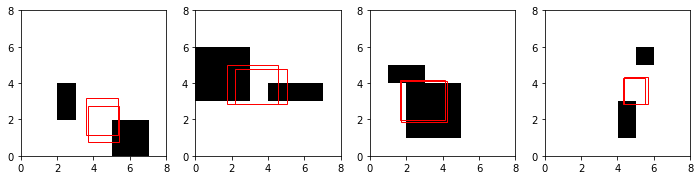

In [11]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))

# plt.savefig('plots/bw-two-rectangles_with-flipping.png', dpi=300)

### Training with Flipping

In [12]:
num_epochs = 30
flipped_train_y = np.array(train_y)
flipped = np.zeros((len(flipped_train_y), num_epochs))
ious_epoch = np.zeros((len(flipped_train_y), num_epochs))
dists_epoch = np.zeros((len(flipped_train_y), num_epochs))
mses_epoch = np.zeros((len(flipped_train_y), num_epochs))

for epoch in range(num_epochs):
    print('Epoch', epoch)
    model.fit(train_X, flipped_train_y, nb_epoch=1, validation_data=(test_X, test_y), verbose=2)
    pred_y = model.predict(train_X)

    for i, (pred_bboxes, exp_bboxes) in enumerate(zip(pred_y, flipped_train_y)):
        
        flipped_exp_bboxes = np.concatenate([exp_bboxes[4:], exp_bboxes[:4]])
        
        mse = np.mean(np.square(pred_bboxes - exp_bboxes))
        mse_flipped = np.mean(np.square(pred_bboxes - flipped_exp_bboxes))
        
        iou = IOU(pred_bboxes[:4], exp_bboxes[:4]) + IOU(pred_bboxes[4:], exp_bboxes[4:])
        iou_flipped = IOU(pred_bboxes[:4], flipped_exp_bboxes[:4]) + IOU(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        dist = distance(pred_bboxes[:4], exp_bboxes[:4]) + distance(pred_bboxes[4:], exp_bboxes[4:])
        dist_flipped = distance(pred_bboxes[:4], flipped_exp_bboxes[:4]) + distance(pred_bboxes[4:], flipped_exp_bboxes[4:])
        
        if mse_flipped < mse:  # you can also use iou or dist here
            flipped_train_y[i] = flipped_exp_bboxes
            flipped[i, epoch] = 1
            mses_epoch[i, epoch] = mse_flipped / 2.
            ious_epoch[i, epoch] = iou_flipped / 2.
            dists_epoch[i, epoch] = dist_flipped / 2.
        else:
            mses_epoch[i, epoch] = mse / 2.
            ious_epoch[i, epoch] = iou / 2.
            dists_epoch[i, epoch] = dist / 2.
    
    print('Flipped {} % of all elements'.format(np.mean(flipped[:, epoch]) * 100.))
    print('Mean IOU: {}'.format(np.mean(ious_epoch[:, epoch])))
    print('Mean dist: {}'.format(np.mean(dists_epoch[:, epoch])))
    print('Mean mse: {}'.format(np.mean(mses_epoch[:, epoch])))
    print()

Epoch 0
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0163 - val_loss: 0.0161
Flipped 42.089999999999996 % of all elements
Mean IOU: 0.1766118363501419
Mean dist: 0.1894799903661532
Mean mse: 0.00699434824915678

Epoch 1
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0138 - val_loss: 0.0176
Flipped 17.1225 % of all elements
Mean IOU: 0.22431194141302313
Mean dist: 0.1592711180509486
Mean mse: 0.005442893507689215

Epoch 2
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0114 - val_loss: 0.0200
Flipped 9.065 % of all elements
Mean IOU: 0.28546079004628777
Mean dist: 0.13210699722538216
Mean mse: 0.0043008153705971115

Epoch 3
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0099 - val_loss: 0.0220
Flipped 6.59 % of all elements
Mean IOU: 0.33596332958980635
Mean dist: 0.11401574462132717
Mean mse: 0.003600266977493378

Epoch 4
Train on 40000 samples, validate on 10000 sam

Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0049 - val_loss: 0.0270
Flipped 0.4575 % of all elements
Mean IOU: 0.5441900941948147
Mean dist: 0.055843278083214286
Mean mse: 0.0014027309568809265

Epoch 27
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0048 - val_loss: 0.0272
Flipped 0.3875 % of all elements
Mean IOU: 0.5449334748608083
Mean dist: 0.05576642630364876
Mean mse: 0.001400631396653385

Epoch 28
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0048 - val_loss: 0.0271
Flipped 0.475 % of all elements
Mean IOU: 0.5491012312639744
Mean dist: 0.05521039722591471
Mean mse: 0.0013792712165849545

Epoch 29
Train on 40000 samples, validate on 10000 samples
40000/40000 - 2s - loss: 0.0048 - val_loss: 0.0274
Flipped 0.41250000000000003 % of all elements
Mean IOU: 0.5492368570637863
Mean dist: 0.05472830885599281
Mean mse: 0.0013717838361254828



### Results of training with flipping

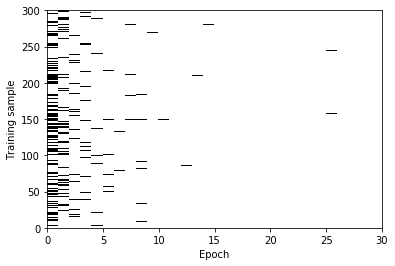

In [13]:
# Show flippings for a few training samples.
plt.pcolor(flipped[:300], cmap='Greys')
plt.xlabel('Epoch')
plt.ylabel('Training sample')
plt.show()

# plt.savefig('plots/bw-two-rectangles_flips.png', dpi=300)

(0, 1)

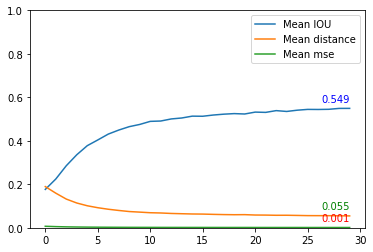

In [14]:
# Plot metrics on the training data. 
mean_ious_epoch = np.mean(ious_epoch, axis=0)
mean_dists_epoch = np.mean(dists_epoch, axis=0)
mean_mses_epoch = np.mean(mses_epoch, axis=0)
plt.plot(mean_ious_epoch, label='Mean IOU')  # between predicted and assigned true bboxes
plt.plot(mean_dists_epoch, label='Mean distance')  # relative to image size
plt.plot(mean_mses_epoch, label='Mean mse')
plt.annotate(np.round(np.max(mean_ious_epoch), 3), (len(mean_ious_epoch)-1, mean_ious_epoch[-1]+0.03), horizontalalignment='right', color='b')
plt.annotate(np.round(np.min(mean_dists_epoch), 3), (len(mean_dists_epoch)-1, mean_dists_epoch[-1]+0.03), horizontalalignment='right', color='g')
plt.annotate(np.round(np.min(mean_mses_epoch), 3), (len(mean_mses_epoch)-1, mean_mses_epoch[-1]+0.03), horizontalalignment='right', color='r')

plt.legend()
plt.ylim(0, 1)

In [15]:
# Predict bounding boxes on the test images.
pred_y = model.predict(test_X)
pred_bboxes = pred_y * img_size
pred_bboxes = pred_bboxes.reshape(len(pred_bboxes), num_objects, -1)
pred_bboxes.shape

(10000, 2, 4)

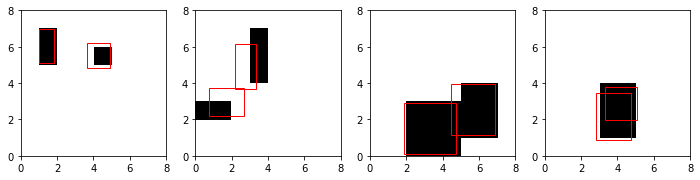

In [16]:
# Show a few images and predicted bounding boxes from the test dataset. 
plt.figure(figsize=(12, 3))
for i_subplot in range(1, 5):
    plt.subplot(1, 4, i_subplot)
    i = np.random.randint(len(test_X))
    plt.imshow(test_imgs[i].T, cmap='Greys', interpolation='none', origin='lower', extent=[0, img_size, 0, img_size])
    for pred_bbox, exp_bbox in zip(pred_bboxes[i], test_bboxes[i]):
        plt.gca().add_patch(matplotlib.patches.Rectangle((pred_bbox[0], pred_bbox[1]), pred_bbox[2], pred_bbox[3], ec='r', fc='none'))

# plt.savefig('plots/bw-two-rectangles_with-flipping.png', dpi=300)